In [4]:
import pandas as pd
import numpy as np
import sys
import pickle
import glob
import os
import matplotlib.pyplot as plt
import sqlite3

In [5]:
EXPERIMENT_DIR = '/data2/experiments/P3856'
# EXPERIMENT_DIR = '/Users/darylwilding-mcbride/Downloads/experiments/dwm-test'
MINIMUM_NUMBER_OF_RUNS = 5

In [7]:
EXTRACTED_FEATURES_DIR = "{}/extracted-features".format(EXPERIMENT_DIR)
EXTRACTED_FEATURES_DB_NAME = "{}/extracted-features.sqlite".format(EXTRACTED_FEATURES_DIR)

#### look at sequences that appear in more half the runs in the experiment

In [34]:
subset_group = 'YHE114'

In [58]:
db_conn = sqlite3.connect(EXTRACTED_FEATURES_DB_NAME)
sequences_df = pd.read_sql_query('select sequence,charge,file_idx,peak_idx,human,run_name,intensity,isotope_idx_not_in_saturation,inferred,run_group,short_run_name from features where run_group==\'{}\' order by intensity desc'.format(subset_group), db_conn)
sequences_df.human = sequences_df.human.astype(bool)
sequences_df.inferred = sequences_df.inferred.astype(bool)
db_conn.close()


In [59]:
sequences_df['log_intensity'] = np.log2(sequences_df.intensity)

In [88]:
sequences_df.sample(10).sort_values(by=['intensity','sequence','charge'], ascending=False, inplace=False)


,sequence,charge,file_idx,peak_idx,human,run_name,intensity,isotope_idx_not_in_saturation,inferred,run_group,short_run_name,log_intensity
7,MSVQPTVSLGGFEITPPVVLR,2,14,0,True,P3856_YHE114_1_Slot1-1_1_5115,41677,4,True,YHE114,YHE114_1,15.346964
141,TIGGGDDSFNTFFSETGAGK,2,14,0,True,P3856_YHE114_1_Slot1-1_1_5115,26745,3,True,YHE114,YHE114_1,14.706982
216,LAMQEFMILPVGAANFR,2,4,0,True,P3856_YHE114_2_Slot1-1_1_5116,23971,3,True,YHE114,YHE114_2,14.549002
264,YGIICMEDLIHEIYTVGK,3,15,0,True,P3856_YHE114_3_Slot1-1_1_5117,22674,3,True,YHE114,YHE114_3,14.468751
298,GLGTDEDTLIEILASR,2,12,0,True,P3856_YHE114_7_Slot1-1_1_5121,21862,3,True,YHE114,YHE114_7,14.416138
425,VPFCPMVGSEVYSTEIK,2,11,0,True,P3856_YHE114_8_Slot1-1_1_5122,18929,3,True,YHE114,YHE114_8,14.208311
505,VWLDPNETNEIANANSR,2,6,0,True,P3856_YHE114_5_Slot1-1_1_5119,17255,3,True,YHE114,YHE114_5,14.074727
547,GIIWGEDTLMEYLENPK,2,3,0,True,P3856_YHE114_9_Slot1-1_1_5123,16314,3,True,YHE114,YHE114_9,13.993823
654,AGAIAPCEVTVPAQNTGLGPEK,2,14,0,True,P3856_YHE114_1_Slot1-1_1_5115,13605,3,True,YHE114,YHE114_1,13.731849
774,DQQEAALVDMVNDGVEDLR,2,14,0,True,P3856_YHE114_1_Slot1-1_1_5115,9193,2,True,YHE114,YHE114_1,13.166320


#### analyse a selected sequence across the experiment for runs in which it was classified as a target

In [93]:
selected_sequence = 'MSVQPTVSLGGFEITPPVVLR'
selected_sequence_charge = 2

In [94]:
selected_sequence_df = sequences_df[(sequences_df.sequence == selected_sequence) & (sequences_df.charge == selected_sequence_charge)].copy()
selected_sequence_df.sort_values(by=['short_run_name'], inplace=True)

#### compare the intensities across the experiment for the selected sequence

In [95]:
MAX_SUMMED_APEX_POINTS = 3 * 3000

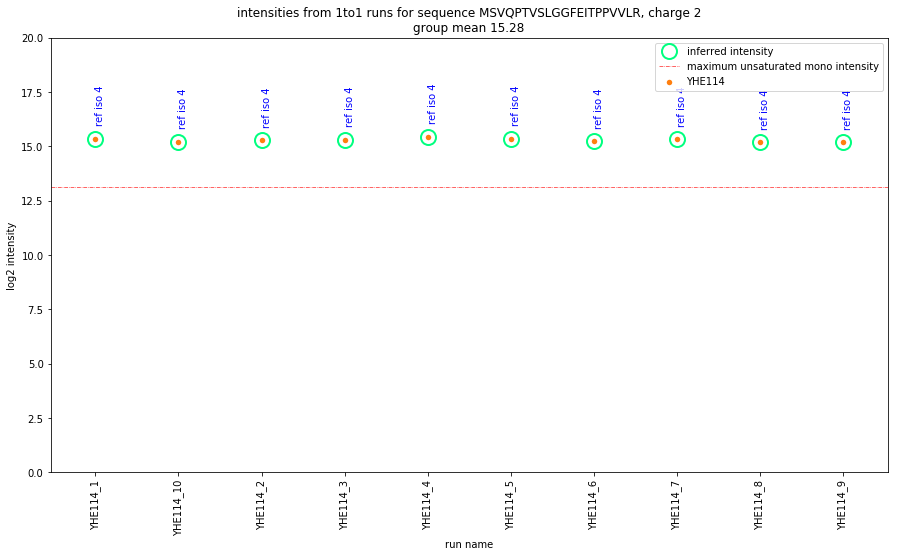

In [96]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

mean_group = round(np.mean(np.log2(selected_sequence_df.intensity)), 2)

plt.title('intensities from 1to1 runs for sequence {}, charge {}\ngroup mean {}'.format(selected_sequence, selected_sequence_charge, mean_group))

ax1.scatter(selected_sequence_df.short_run_name, selected_sequence_df.log_intensity, marker='o', color='tab:orange', lw=0, s=30, alpha=1.0, label=subset_group)

# highlight whether a point was adjusted for saturation
adj_sat = selected_sequence_df[(selected_sequence_df.isotope_idx_not_in_saturation > 0)]
if len(adj_sat) > 0:
    ax1.plot(adj_sat.short_run_name, adj_sat.log_intensity, marker='o', markerfacecolor='none', markeredgecolor='springgreen', linestyle='', markeredgewidth=2, ms=15, label='inferred intensity')

# show which isotope was used as a reference
text_style = dict(size=10, color='blue')
for idx,row in adj_sat.iterrows():
    ax1.text(row.short_run_name, row.log_intensity+2.1, "ref iso {}".format(int(row.isotope_idx_not_in_saturation)), **text_style, rotation=90)

plt.axhline(y=np.log2(MAX_SUMMED_APEX_POINTS), color='red', linestyle='-.', linewidth=0.6, label='maximum unsaturated mono intensity')

plt.xlabel('run name')
plt.ylabel('log2 intensity')
plt.legend(loc='best')

# plt.xlim((0,50))
plt.ylim((0,20))
plt.xticks(rotation=90)

plt.show()

#### look at the distribution of intensity CV across the group runs

In [78]:
# find the intensity CV of each sequence in the runs
sequence_intensity_cv_l = []
for group_name,group_df in sequences_df.groupby(['sequence','charge'], as_index=False):
    if len(group_df) >= 2:
        sequence = group_name[0]
        charge = group_name[1]
        sequence_intensity_cv = np.std(group_df.intensity) / np.mean(group_df.intensity)
        sequence_intensity_cv_l.append((sequence,charge,sequence_intensity_cv))
sequence_intensity_cv_df = pd.DataFrame(sequence_intensity_cv_l, columns=['sequence','charge','intensity_cv'])


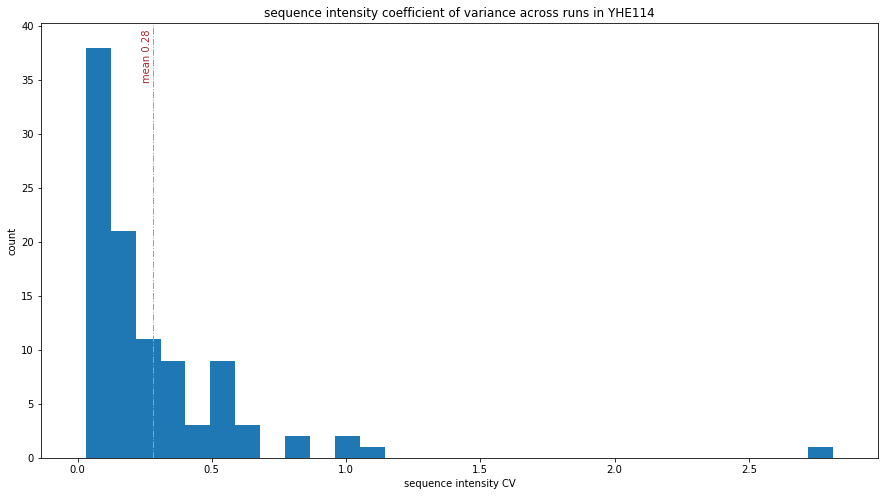

In [79]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 30
values = sequence_intensity_cv_df.intensity_cv
y, x, _ = ax1.hist(values, bins=bins)
mean = np.mean(values)
ax1.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
ax1.text(mean*0.85, y.max()*0.98, "mean {}".format(round(mean,2)), **text_style, rotation='vertical')

plt.xlabel('sequence intensity CV')
plt.ylabel('count')
plt.title('sequence intensity coefficient of variance across runs in {}'.format(subset_group))

plt.show()